### Imports

In [5]:
#IF NEED BE INSTALL THE LIBRARIES NEEDED BEFORE THIS CELL
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

### Preprocessing and Callback

In [2]:
# Define a callback to compute testing MSE after each epoch
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.test_data
        loss = self.model.evaluate(x, y, verbose=0)
        self.test_loss.append(loss)
        print(f'Testing loss for epoch {epoch + 1}: {loss}')
        
        # Load data
data = pd.read_csv('vgsales.csv')

# Drop rows with missing valuesS
data.dropna(inplace=True)

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter any outliers
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


data_filtered = remove_outliers(data, 'Global_Sales')

# features and target
X = data_filtered[['Platform', 'Year', 'Genre', 'Publisher']]
y = data_filtered['Global_Sales']

numeric_features = ['Year']
numeric_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_features = ['Platform', 'Genre', 'Publisher']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Preprocess the data
X_preprocessed = pipeline.fit_transform(X)

### Model Definition and Training


In [3]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=46)

# Model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1) 
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Instantiate the TestCallback with test dataS
test_callback = TestCallback((X_test, y_test))

# Train the model with callback to evaluate test loss
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test), verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions to calculate R-Squared
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R-Squared
r_squared_train = r2_score(y_train, y_train_pred)
r_squared_test = r2_score(y_test, y_test_pred)



Epoch 1/20


c:\Users\Dan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0639 - val_loss: 0.0518
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 0.0447 - val_loss: 0.0497
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0421 - val_loss: 0.0494
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 0.0409 - val_loss: 0.0492
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0402 - val_loss: 0.0490
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - loss: 0.0381 - val_loss: 0.0491
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0367 - val_loss: 0.0492
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - loss: 0.0376 - val_loss: 0.0494
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.0368 - val_loss: 0.0489
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - loss: 0.0365 - val_loss: 0.0491
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0349 - val_loss: 0.0494
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 0.03

### Plotting

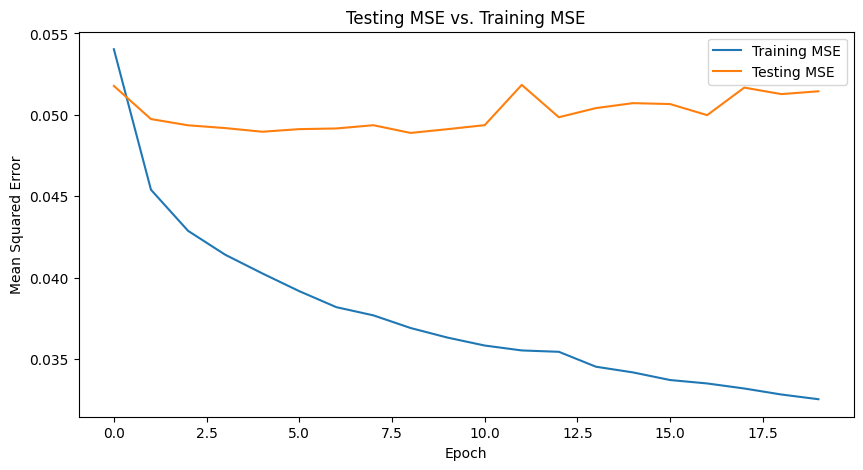

R-squared for training data: 0.4871141049316483
R-squared for testing data: 0.205053617322002
MSE for training data: 0.03077368624508381
MSE for testing data: 0.051450375467538834


In [4]:

# Plotting Test MSE vs. Training MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Testing MSE')
plt.title('Testing MSE vs. Training MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

train_mse = model.evaluate(X_train, y_train, verbose=0)

test_mse = model.evaluate(X_test, y_test, verbose=0)

# Print R-Squared values
print(f'R-squared for training data: {r_squared_train}')
print(f'R-squared for testing data: {r_squared_test}')
print(f'MSE for training data: {train_mse}')
print(f'MSE for testing data: {test_mse}')
